In [95]:
from pathlib import Path

import pandas as pd
import subprocess
import numpy as np
import matplotlib.pyplot as plt

In this notebook, I'll use simulation to inform an appropriate threshold value for the `maximum ambiquity` parameter of Vibecheck. Briefly, this parameters sets how incomplete a sequence can be before its removed by filtering. Missing data will push sequences more basal in the phylogeny, but its unclear at what point they will not be placed in their actual lineage. Pangolin, which uses an identical method, uses a default of 30%, but I'm not sure if that was ever tested empirically.

Here, I'll load the test dataset, select a *complete*, randomly mask a given percentage of the genome, insert the sequence into the guide tree using UShER, and check whether the sequence was correctly placed or not.

In [41]:
vcf = pd.read_csv( "test.usher.vcf", sep="\t", skiprows=3)
vcf = vcf.set_index(['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT'])
vcf.head()

/var/folders/yk/ygy5y6t17g7gptxs3pqtrp240000gn/T/ipykernel_12636/2438098583.py:1: DtypeWarning: Columns (9,10,11,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,51,52,53,55,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,95,96,98,99,100,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,175,176,177,178,179,180,181,182,183,184,185,186,187,189,190,191,192,193,194,195,196,197,198,199,200,201,204,205,207,208,209,210,211,212,213,214,215,216,218,219,220,222,225,228,229,230,231,232,234,236,239,241,242,244,245,246,248,249,251,252,253,256,257,258,261,262,264,266,268,270,273,274,277,279,280,283,284,285,286,287,289,293,297,300,301,302,303,304,305,307,

Africa|TUN|ERR976455|T1|1971-01-01  \
#CHROM   POS  ID     REF ALT QUAL FILTER INFO          FORMAT                                      
AE003852 825  A825G  A   G   .    .      AC=10;AN=307  GT                                      0   
         1439 C1439T C   T   .    .      AC=1;AN=307   GT                                      0   
         1574 C1574T C   T   .    .      AC=1;AN=307   GT                                      0   
         5414 G5414A G   A   .    .      AC=267;AN=307 GT                                      0   
         6000 C6000T C   T   .    .      AC=1;AN=307   GT                                      0   

                                                              Africa|MWI|ERR976523|T1|1992-01-01  \
#CHROM   POS  ID     REF ALT QUAL FILTER INFO          FORMAT                                      
AE003852 825  A825G  A   G   .    .      AC=10;AN=307  GT                                      0   
         1439 C1439T C   T   .    .      AC=1;AN=307   GT                                      0   
         1574 C1574T C   T   .    .      AC=1;AN=307   GT                                      0   
         5414 G5414A G   A   .    .      AC=267;AN=307 GT                                      0   
         6000 C6000T C   T   .    .      AC=1;AN=307   GT                                      0   

                                                              Africa|DZA|ERR976413|T1|1974-01-01  \
#CHROM   POS  ID     REF ALT QUAL FILTER INFO          FORMAT                                      
AE003852 825  A825G  A   G   .    .      AC=10;AN=307  GT                                      0   
         1439 C1439T C   T   .    .      AC=1;AN=307   GT                                      0   
         1574 C1574T C   T   .    .      AC=1;AN=307   GT                                      0   
         5414 G5414A G   A   .    .      AC=267;AN=307 GT                                      0   
         6000 C6000T C   T   .    .      AC=1;AN=307   GT                                      0   

                                                              Africa|SEN|ERR976435|T1|1972-01-01  \
#CHROM   POS  ID     REF ALT QUAL FILTER INFO          FORMAT                                      
AE003852 825  A825G  A   G   .    .      AC=10;AN=307  GT                                      0   
         1439 C1439T C   T   .    .      AC=1;AN=307   GT                                      0   
         1574 C1574T C   T   .    .      AC=1;AN=307   GT                                      0   
         5414 G5414A G   A   .    .      AC=267;AN=307 GT                                      0   
         6000 C6000T C   T   .    .      AC=1;AN=307   GT                                      0   

                                                              Africa|CIV|ERR976425|T1|1973-01-01  \
#CHROM   POS  ID     REF ALT QUAL FILTER INFO          FORMAT                                      
AE003852 825  A825G  A   G   .    .      AC=10;AN=307  GT                                      0   
         1439 C1439T C   T   .    .      AC=1;AN=307   GT                                      0   
         1574 C1574T C   T   .    .      AC=1;AN=307   GT                                      0   
         5414 G5414A G   A   .    .      AC=267;AN=307 GT                                      0   
         6000 C6000T C   T   .    .      AC=1;AN=307   GT                                      0   

                                                              Africa|MWI|ERR976392|T1|1990-01-01  \
#CHROM   POS  ID     REF ALT QUAL FILTER INFO          FORMAT                                      
AE003852 825  A825G  A   G   .    .      AC=10;AN=307  GT                                      0   
         1439 C1439T C   T   .    .      AC=1;AN=307   GT                                      0   
         1574 C1574T C   T   .    .      AC=1;AN=307   GT                                      0   
         5414 G5414A G   A   .    .      AC=267;AN=307 GT

Next, I'll load the set of all sequences in the VCF that fall into a canonical lineage (i.e. lots of sequences are from Asia, and we don't have a way of testing their placement at the moment).

In [42]:
lin = pd.read_csv( "te_lineages.tsv", sep="\t" )
lin = lin.loc[lin["taxa"].isin(vcf.columns)&(lin["te"]!="UNK")]
lin.head()

,te,taxa
0,T12,Africa|CMR|CMR_CEN005NA35|T12|2023-04-12
42,T10,Africa|COD|DC-0130107|T10|2023-01-03
45,T10,Africa|COD|DC-0007121|T10|2023-01-03
47,T10,Africa|COD|DC-0217106|T10|2022-01-06
56,T10,Africa|COD|DC-0011127|T10|2023-01-02


In [43]:
missing_variants = (vcf[lin["taxa"]] == ".").sum()
missing_variants.name = "missing"
lin = lin.merge( missing_variants, how="left", left_on="taxa", right_index=True )
lin.head()

,te,taxa,missing
0,T12,Africa|CMR|CMR_CEN005NA35|T12|2023-04-12,18
42,T10,Africa|COD|DC-0130107|T10|2023-01-03,15
45,T10,Africa|COD|DC-0007121|T10|2023-01-03,19
47,T10,Africa|COD|DC-0217106|T10|2022-01-06,66
56,T10,Africa|COD|DC-0011127|T10|2023-01-02,19


In [110]:
usher_results = {
    "fraction_missing" : list(),
    "trial" : list(),
    "result" : list(),
    "sample" : list()
}

samples = ["Africa|GHA|637b8a3aca78020381667170|T9|2012-01-01", "Africa|GHA|637b8a3aca7802699b66716a|T12|2015-01-01", "Africa|MWI|SRS17567770|T15|2023-01-01", "Africa|DRC|C-KES-21-0086|T10|2021-11-29", "Africa|MWI|MWI-VC-27|T13|2018-01-01", "Africa|MWI|MW_NGSRL_82_23CHOL|T15|2022-04-01"]
pb = "../vibecheck/resources/o1_cholera.no_missing.pb"
for frac in np.arange(0.05, 1, 0.05):
    for trial in range( 10 ):
        temp_dir = Path( f"tmp/{trial}-{frac}/")
        temp_dir.mkdir( parents=True, exist_ok=True )
        for sample in samples:
            temp_vcf = temp_dir / "masked_sequence.vcf"

            vcf.sample(frac=frac, replace=False )[sample].to_csv( temp_vcf, sep="\t" )

            subprocess.run( f"usher -n -D -i {pb} -v {temp_vcf} -T 12 -d {temp_dir}", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT )

            result = (temp_dir / "clades.txt").read_text()
            result = result.split()[1]
            usher_results["fraction_missing"].append( 1-frac )
            usher_results["trial"].append( trial )
            usher_results["result"].append( result )
            usher_results["sample"].append( sample)
    print( f"Finished {frac}" )

Finished 0.05
Finished 0.1
Finished 0.15000000000000002
Finished 0.2
Finished 0.25
Finished 0.3
Finished 0.35000000000000003
Finished 0.4
Finished 0.45
Finished 0.5
Finished 0.55
Finished 0.6000000000000001
Finished 0.6500000000000001
Finished 0.7000000000000001
Finished 0.7500000000000001
Finished 0.8
Finished 0.8500000000000001
Finished 0.9000000000000001
Finished 0.9500000000000001


In [112]:
usher_results = pd.DataFrame(usher_results )
usher_results["lineage"] = usher_results["result"].apply( lambda x: x.split( "*|" )[0] )
usher_results["actual"] = usher_results["sample"].apply( lambda x: x.split( "|" )[3] )
usher_results["correct"] = usher_results["lineage"] == usher_results["actual"]
usher_results.head()

,fraction_missing,trial,result,sample,lineage,actual,correct
0,0.95,0,T10*|T10(1/1),Africa|GHA|637b8a3aca78020381667170|T9|2012-01-01,T10,T9,False
1,0.95,0,"T10*|T10(1/2),UNDEFINED(1/2)",Africa|GHA|637b8a3aca7802699b66716a|T12|2015-0...,T10,T12,False
2,0.95,0,T10*|T10(1/1),Africa|MWI|SRS17567770|T15|2023-01-01,T10,T15,False
3,0.95,0,T10*|T10(1/1),Africa|DRC|C-KES-21-0086|T10|2021-11-29,T10,T10,True
4,0.95,0,T10*|T10(1/1),Africa|MWI|MWI-VC-27|T13|2018-01-01,T10,T13,False


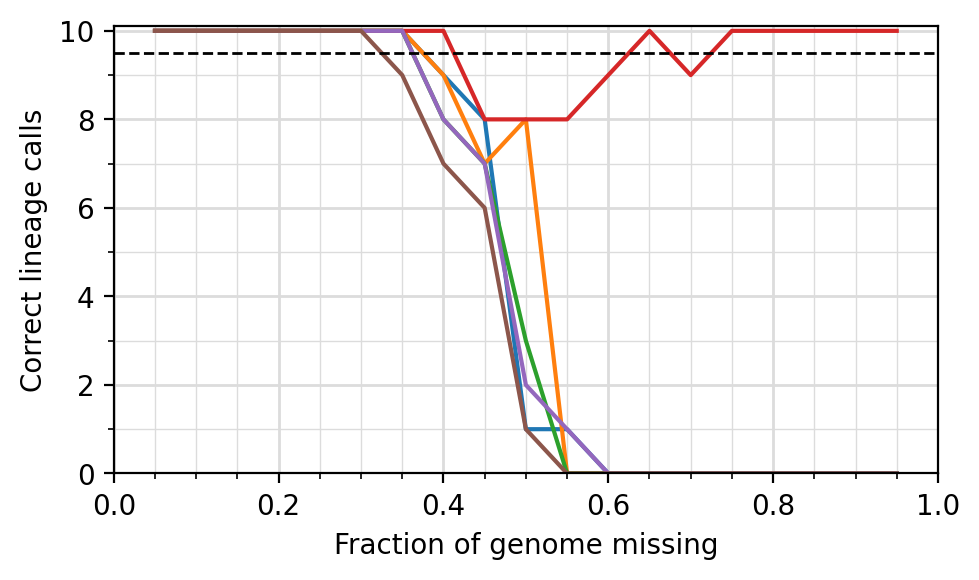

In [113]:
summ = usher_results.pivot_table( columns="sample", index="fraction_missing", values="correct", aggfunc="sum", fill_value=0 )

fig, ax = plt.subplots( dpi=200, figsize=(5,3) )
summ.plot(y=samples, legend=False, ax=ax )
ax.set_xticks( np.arange( 0, 1.05, 0.05), minor=True )
ax.set_xticks( np.arange( 0, 1.2, 0.2), minor=False )
ax.set_yticks( np.arange( 0, 11, 1), minor=True )
ax.set_yticks( np.arange( 0, 12, 2), minor=False )
ax.set_ylim( 0, 10.1)
ax.set_xlabel( "Fraction of genome missing" )
ax.set_ylabel( "Correct lineage calls" )
ax.grid( color="gainsboro", linewidth=1 )
ax.grid( color="gainsboro", linewidth=0.5, which="minor" )
ax.axhline( 9.5, color="k", linestyle="--", linewidth=1 )

plt.tight_layout()

